# Cylindrical MC Waves Solver
## Packages & SLEPc

In [1]:
# === USEFUL PACKAGES ===
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import eig, eigh
from scipy.special import yv, jv, jvp, kv, kvp
from scipy.optimize import root_scalar
from scipy.interpolate import griddata
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from petsc4py import PETSc
from slepc4py import SLEPc

In [2]:
# ---------------------------------------------------------------
# SLEPc for A u = ω B u 
# ---------------------------------------------------------------
def solve_evp_slepc(A, B, omega_target, nev=10, tol=1e-8, max_it=300):

    n = A.shape[0]
    assert A.shape == B.shape == (n, n)

    # -----------------------------------------------------------
    # Matrices PETSc
    # -----------------------------------------------------------
    A_p = PETSc.Mat().createAIJ(A.shape)
    B_p = PETSc.Mat().createAIJ(B.shape)
    A_p.setUp()
    B_p.setUp()

    rows = np.arange(n, dtype=np.int32)

    for i in range(n):
        A_p.setValues(i, rows, A[i, :])
        B_p.setValues(i, rows, B[i, :])

    A_p.assemble()
    B_p.assemble()

    # -----------------------------------------------------------
    # EPS solver
    # -----------------------------------------------------------
    E = SLEPc.EPS().create()
    E.setOperators(A_p, B_p)

    # General case
    E.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

    # -----------------------------------------------------------
    # Dimensions du sous-espace
    # -----------------------------------------------------------
    ncv = max(4*nev, 20)
    mpd = ncv
    E.setDimensions(nev, ncv, mpd)

    # -----------------------------------------------------------
    # Ciblage d'une valeur propre réelle
    # -----------------------------------------------------------
    E.setTarget(omega_target)
    E.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_REAL)

    # -----------------------------------------------------------
    # Shift-invert
    # -----------------------------------------------------------
    ST = E.getST()
    ST.setType(SLEPc.ST.Type.SINVERT)
    ST.setShift(omega_target)

    ksp = ST.getKSP()
    ksp.setType('preonly')

    pc = ksp.getPC()
    pc.setType('lu')
    pc.setFactorSolverType('mumps')

    # -----------------------------------------------------------
    # Tolérances 
    # -----------------------------------------------------------
    E.setTolerances(tol, max_it)
    E.setFromOptions()

    # -----------------------------------------------------------
    # Solve
    # -----------------------------------------------------------
    E.solve()

    nconv = E.getConverged()
    if nconv == 0:
        raise RuntimeError("SLEPc : aucune valeur propre convergée.")

    # -----------------------------------------------------------
    # Extraction des modes 
    # -----------------------------------------------------------
    omegas = np.zeros(nconv, dtype=complex)
    vecs   = np.zeros((n, nconv), dtype=complex)

    xr = PETSc.Vec().createSeq(n)
    xi = PETSc.Vec().createSeq(n)

    for i in range(nconv):
        lam = E.getEigenvalue(i)
        E.getEigenvector(i, xr, xi)
        omegas[i] = lam
        vecs[:, i] = xr.getArray() + 1j * xi.getArray()

    # -----------------------------------------------------------
    # Sélection du mode physique (proche de ω_target)
    # -----------------------------------------------------------
    score = np.abs(omegas.real - omega_target) + 0.1*np.maximum(omegas.imag, 0)
    idx = np.argmin(score)

    omega_dom = omegas[idx]
    u_dom = vecs[:, idx].copy()

    # Normalisation simple
    u_dom /= np.max(np.abs(u_dom))

    return omega_dom, u_dom


## Assemble & Compute Equations

In [67]:
# === CHEBYSHEV MATRIX ===
def cheb_diff(N):
    if N == 0:
        return np.array([[0]]), np.array([1])
    x = -np.cos(np.pi * np.arange(N + 1) / N) # points sur [-1, 1] (ordre croissant, d'où le signe -)
    # Chebyshev coefficients 
    c = np.ones(N + 1) ; c[0], c[-1] = 2, 2 ; c *= (-1) ** np.arange(N + 1)
    # Computation of matrix D
    X = np.tile(x, (N + 1, 1)).T ; dX = X - X.T + np.eye(N + 1)
    D = (np.outer(c, 1 / c)) / dX ; D -= np.diag(np.sum(D, axis=1))
    # s on [0, 1]
    s = 0.5 * (x + 1)
    return 2 * D, s

# === MAGNETIC BOUNDARY CONDITIONS ===
def compute_F1_dF1_G1(m, k, a=1.0, C=1.0):
    F1 = C * kv(m, k*a)
    dF1 = C * k * kvp(m, k*a)
    G1 = 0
    return F1, dF1, G1

# === IDEAL MHD ===
def omega_MC_ideal(m, n, h, a, Omega_rot, Le, k):
    # Greenspan's equation 
    eq = lambda xi: xi * jvp(abs(m), xi, 1) + m * np.sqrt(1 + (xi**2 * h**2)/(n**2 * np.pi**2 * a**2)) * jv(abs(m), xi)
    xi_vals = np.linspace(1e-4, 200, 1000)
    f_vals = [eq(xi) for xi in xi_vals]
    roots = [root_scalar(eq, bracket=[xi_vals[i], xi_vals[i+1]], method='brentq').root
             for i in range(len(xi_vals)-1) if f_vals[i]*f_vals[i+1] < 0]

    if not roots: return np.nan
    xi0 = roots[0]
    omega_I = 2 / np.sqrt(1 + (xi0**2 * h**2)/(n**2 * np.pi**2 * a**2))
    # Ideal MHD frequency
    return (Omega_rot * omega_I / 2) * (1 + np.sqrt(1 + (4 * Le**2 * k**2)/(Omega_rot**2 * omega_I**2)))

def solve_mhd_evp(
    N,
    *,
    h=1.0,
    a=1.0,
    m=2,
    n_axial=1,
    B0=1.0,
    Omega_rot=1.0,
    rho=1.0,
    mu0=1.0,
    mu=1e-3,
    eta=1e-3,
    nev=6,
    tol=1e-8,
):
    # -------------------
    # Derived parameters
    # -------------------
    k = n_axial * np.pi / h
    nu = mu / rho
    v = B0 / np.sqrt(mu0 * rho)
    Le = v / (Omega_rot * h)

    F1_val, dF1_val, _ = compute_F1_dF1_G1(m, k, a=a, C=1.0)
    omega_MC = omega_MC_ideal(m, n_axial, h, a, Omega_rot, Le, k)

    # -------------------
    # Chebyshev matrices
    # -------------------
    D, s = cheb_diff(N)
    D2 = D @ D
    D3 = D2 @ D
    D4 = D2 @ D2

    n_p = N + 1
    size = 4 * n_p

    T_idx = np.arange(0, n_p)
    P_idx = np.arange(n_p, 2 * n_p)
    G_idx = np.arange(2 * n_p, 3 * n_p)
    F_idx = np.arange(3 * n_p, 4 * n_p)

    I = np.eye(n_p)
    A = np.zeros((size, size), dtype=complex)
    B = np.zeros((size, size), dtype=complex)

    # ============================
    # Assembly loop
    # ============================
    for j, sj in enumerate(s):

        row_T = j
        row_P = n_p + j
        row_G = 2 * n_p + j
        row_F = 3 * n_p + j

        # -------- Centre (s = 0)
        if j == 0:
            # Toroïdal hydro
            A[row_T, T_idx[0]] = 1            # T(0) = 0

            # Magnétique
            A[row_F, F_idx[0]] = 1            # F(0) = 0
            A[row_G, G_idx[0]] = 1            # G(0) = 0

            # Poloïdal hydro (parité)
            if m % 2 != 0:
                A[row_P, P_idx[0]] = 1        # P(0) = 0
            else:
                A[row_P, P_idx] = D[0, :]     # P'(0) = 0

            continue

        # -------- Wall (s = 1)
        if j == N:
            alpha2 = k**2 + m**2

            # --- Hydrodynamique ---

            # Toroïdal & Poloïdal : no-slip
            A[row_T, T_idx[-1]] = 1           # T(1) = 0
            A[row_P, P_idx[-1]] = 1           # P(1) = 0
            A[row_P - 1, P_idx] = D[-1, :]    # P'(1) = 0

            # --- Magnétique ---

            if abs(F1_val) > 1e-10:
                alpha = dF1_val / F1_val
                A[row_F, F_idx] = (
                    D[-1, :] - alpha * np.eye(n_p)[-1, :]
                )
            else:
                A[row_F, F_idx[-1]] = 1       # F(1) = 0

            A[row_G, G_idx[-1]] = 1           # G(1) = 0

            continue

        # ============================
        #        INTERIORS POINTS
        # ============================
        sj = s[j]

        # ------------------------------
        # Équation 1 : row_T
        # ------------------------------
        row = row_T

        coef0_1T = nu * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
        coef1_1T = nu * (-k**2 * sj + m**2/sj)
        coef2_1T = nu * (-k**2 * sj**2 - m**2)
        A[row, T_idx] += (coef0_1T * np.eye(n_p)[j] + coef1_1T * D[j] + coef2_1T * D2[j])

        coef0_1P = -2j * Omega_rot * (k**3 * sj**2 + k * m**2) \
                    + nu * (-4 * k**3 * m - (4/sj**2) * k * m**3 + (4/sj**2) * k * m)
        coef1_1P =  - 4 * k * m * nu/sj
        coef2_1P =  - 4 * k * m * nu
        A[row, P_idx] += (coef0_1P * np.eye(n_p)[j] + coef1_1P * D[j] + coef2_1P * D2[j])

        A[row, G_idx[j]] = (-1j * B0 /(mu0 * rho) * (k**3 * sj**2 + k * m**2))
        A[row, F_idx[j]] = (-2j * B0 /(mu0 * rho) * (k**2 * m))

        # ω-terms
        B[row, T_idx[j]] = (1j * (k**2 * sj**2 + m**2))
        B[row, P_idx[j]] = (2j * k * m)

        # ------------------------------
        # Équation 2 : row_P
        # ------------------------------
        row = row_P

        coef0_2T = 2j * Omega_rot * (k**3 * sj**2 + k * m**2) \
                    + nu * (4/sj**2 *(k * m - k * m**3) - 4 * k**3 * m)
        coef1_2T = - 4/sj * k * m * nu
        coef2_2T =  4 * k * m * nu
        A[row, T_idx] += (coef0_2T * np.eye(n_p)[j] + coef1_2T * D[j] + coef2_2T * D2[j])

        coef0_2P = 4j * Omega_rot * k**2 * m \
                + nu * (k**6 * sj**2 + 3 * k**4 * m**2 + 2 * k**4 \
                + 3/sj**2 * k**2 * m**4 + (m**6 - 10 * m**4 + 9 * m**2)/sj**4 - 3 * k**2/sj**2)
        coef1_2P = nu * (-2 * k**4 * sj + 4/sj * k**2 * m**2 \
                        + (6 * m**4 - 9 * m**2)/sj**3 + 3/sj * k**2)
        coef2_2P = nu * (-2 * k**4 * sj**2 - 4 * k**2 * m**2 - 3 * k**2 \
                        - (2 * m**4 - 5 * m**2)/sj**2)
        coef3_2P = nu * (2 * k**2 * sj - 2/sj * m**2)
        coef4_2P = nu * (k**2 * sj**2 + m**2)
        A[row, P_idx] += (coef0_2P*np.eye(n_p)[j] + coef1_2P*D[j] + coef2_2P*D2[j]
                        + coef3_2P*D3[j] + coef4_2P*D4[j])

        A[row, G_idx[j]] = (2j * B0 /(mu0 * rho) * k**2 * m)

        coef0_2F = 1j * B0 /(mu0 * rho) * (k**5 * sj**2 + k**3 * (2 * m**2 + 1) \
                    + k * (m**4 - m**2)/sj**2)
        coef1_2F = 1j * B0 /(mu0 * rho) * (-k**3 * sj + (k * m**2)/sj)
        coef2_2F = -1j * B0 /(mu0 * rho) * (k**3 * sj**2 + k * m**2)
        A[row, F_idx] += (coef0_2F*np.eye(n_p)[j] + coef1_2F*D[j] + coef2_2F*D2[j])

        # ω-terms
        B[row, T_idx[j]] = (-2j * k * m )

        coef0_2BP = 1j * ( -k**4 * sj**2 - (2 * m**2 + 1) * k**2 \
                        + (m**2 - m**4)/sj**2)
        coef1_2BP = -1j * (m**2/sj - k**2 * sj)
        coef2_2BP = 1j * (k**2 * sj**2 + m**2)
        B[row, P_idx] += (coef0_2BP*np.eye(n_p)[j] + coef1_2BP*D[j] + coef2_2BP*D2[j])

        # ------------------------------
        # Équation 3 : row_G
        # ------------------------------
        row = row_G

        A[row, P_idx[j]] = (-1j * B0 * (k**3 * sj**2 + k * m**2))
        A[row, G_idx[j]] = (-2*eta*k*m)

        coef0_3F = eta * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
        coef1_3F = eta * (m**2/sj - k**2 *sj)
        coef2_3F = - eta * (k**2 * sj**2 + m**2)
        A[row, F_idx] += (coef0_3F*np.eye(n_p)[j] + coef1_3F*D[j] + coef2_3F*D2[j])

        # ω-term
        B[row, F_idx[j]] = (1j * (k**2 * sj**2 + m**2))

        # ------------------------------
        # Équation 4 : row_F
        # ------------------------------
        row = row_F

        A[row, T_idx[j]] = (1j * B0 * (k**3 * sj**2 + k * m**2))
        A[row, P_idx[j]] = (2j * B0 * k**2 * m)

        coef0_4G = eta * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
        coef1_4G = eta * (m**2/sj - k**2 *sj)
        coef2_4G = -eta * (k**2 * sj**2 + m**2)
        A[row, G_idx] += (coef0_4G*np.eye(n_p)[j] + coef1_4G*D[j] + coef2_4G*D2[j])

        coef0_4F = -4 * eta * (k**3 * m + (k * m**3 - k * m)/sj**2)
        coef1_4F = -4 * eta * k * m * 1/sj
        coef2_4F = 4 * eta * k * m
        A[row, F_idx] += (coef0_4F*np.eye(n_p)[j] + coef1_4F*D[j] + coef2_4F*D2[j])

        # ω-terms
        B[row, G_idx[j]] = (-1j * (k**2 * sj**2 + m**2))
        B[row, F_idx[j]] = (-2j * k * m)

    # ============================
    # Solve EVP
    # ============================
    omega_dom, u_dom = solve_evp_slepc(
        A, B, omega_MC, nev=nev, tol=tol
    )

    # Residual
    r = A @ u_dom - omega_dom * (B @ u_dom)
    res = np.linalg.norm(r) / (
        (np.linalg.norm(A, ord="fro")
         + abs(omega_dom) * np.linalg.norm(B, ord="fro"))
        * np.linalg.norm(u_dom)
    )

    return {
        "omega": omega_dom,
        "residual": res,
        "s": s,
        "solution": u_dom,
        "indices": (T_idx, P_idx, G_idx, F_idx),
        "omega_MC": omega_MC,
    }


## Results

 Magneto–Coriolis modes
ω_MC (ideal) = 3.8073681069e+00
------------------------------------
ω_NUM = 3.7530079672e+00  + i 4.714e-03
Relative error (Re) = 1.428e-02
Eigenproblem residual = 7.305e-18



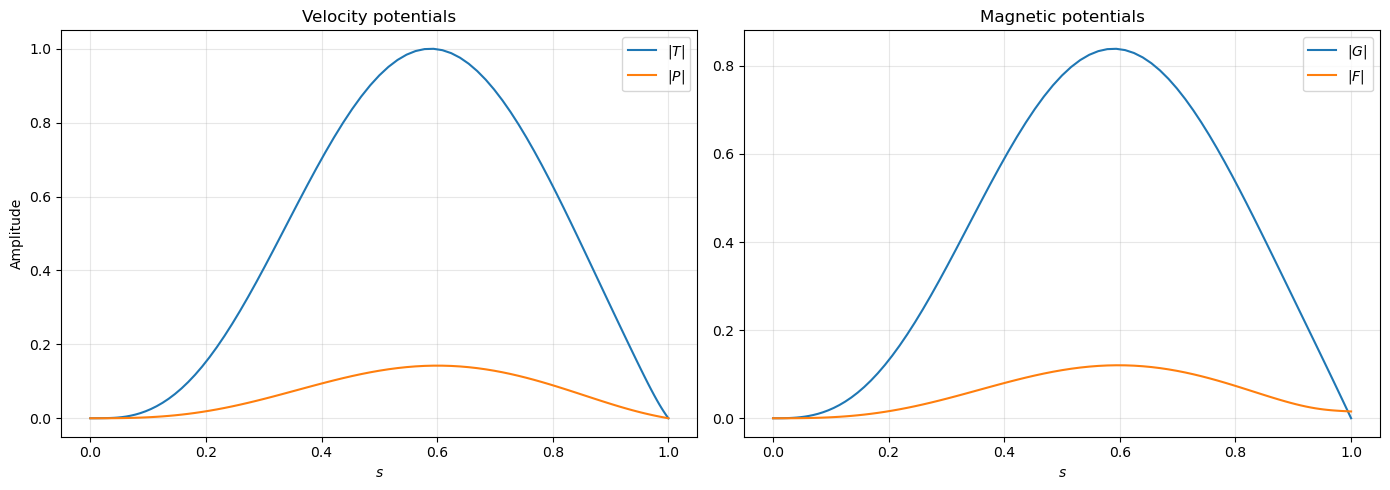

In [82]:
def print_frequency_diagnostics(out):
    omega_num = out["omega"]
    omega_MC  = out.get("omega_MC", None)
    res       = out.get("residual", None)

    print("====================================")
    print(" Magneto–Coriolis modes")
    print("====================================")

    if omega_MC is not None and not np.isnan(omega_MC):
        print(f"ω_MC (ideal) = {omega_MC:.10e}")
    else:
        print("ω_MC (ideal) = not available")

    print("------------------------------------")
    print(f"ω_NUM = {omega_num.real:.10e}  + i {omega_num.imag:.3e}")

    if omega_MC is not None and not np.isnan(omega_MC):
        err = abs(omega_num.real - omega_MC) / abs(omega_MC)
        print(f"Relative error (Re) = {err:.3e}")

    if res is not None:
        print(f"Eigenproblem residual = {res:.3e}")

    print("====================================\n")

def extract_fields(u_dom, indices):
    T_idx, P_idx, G_idx, F_idx = indices
    return (
        u_dom[T_idx],
        u_dom[P_idx],
        u_dom[G_idx],
        u_dom[F_idx],
    )

def plot_eigenvectors(out):
    s = out["s"]
    u = out["solution"]
    indices = out["indices"]

    T, P, G, F = extract_fields(u, indices)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ---- Velocity potentials
    axes[0].plot(s, np.abs(T), label=r"$|T|$")
    axes[0].plot(s, np.abs(P), label=r"$|P|$")
    axes[0].set_title("Velocity potentials")
    axes[0].set_xlabel(r"$s$")
    axes[0].set_ylabel("Amplitude")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # ---- Magnetic potentials
    axes[1].plot(s, np.abs(G), label=r"$|G|$")
    axes[1].plot(s, np.abs(F), label=r"$|F|$")
    axes[1].set_title("Magnetic potentials")
    axes[1].set_xlabel(r"$s$")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def result(
    *,
    N=100,
    m=2,
    n_axial=1,
    eta=0.01,
    mu=0.01,
    h=1.0,
    a=1.0,
    B0=1.0,
    Omega_rot=1.0,
    rho=1.0,
    mu0=1.0,
    nev=6,
    tol=1e-8,
    plot=True,
):
    """
    Solve EVP, print diagnostics, and plot eigenvectors.
    """

    out = solve_mhd_evp(
        N=N,
        m=m,
        n_axial=n_axial,
        eta=eta,
        mu=mu,
        h=h,
        a=a,
        B0=B0,
        Omega_rot=Omega_rot,
        rho=rho,
        mu0=mu0,
        nev=nev,
        tol=tol,
    )

    # ---- Print diagnostics
    print_frequency_diagnostics(out)

    # ---- Plot eigenvectors
    if plot:
        plot_eigenvectors(out)

    return out

out = result(
    N=100,
    m=2,
    n_axial=1,
    eta=0.01,
    mu=0.001,
)


## Convergence

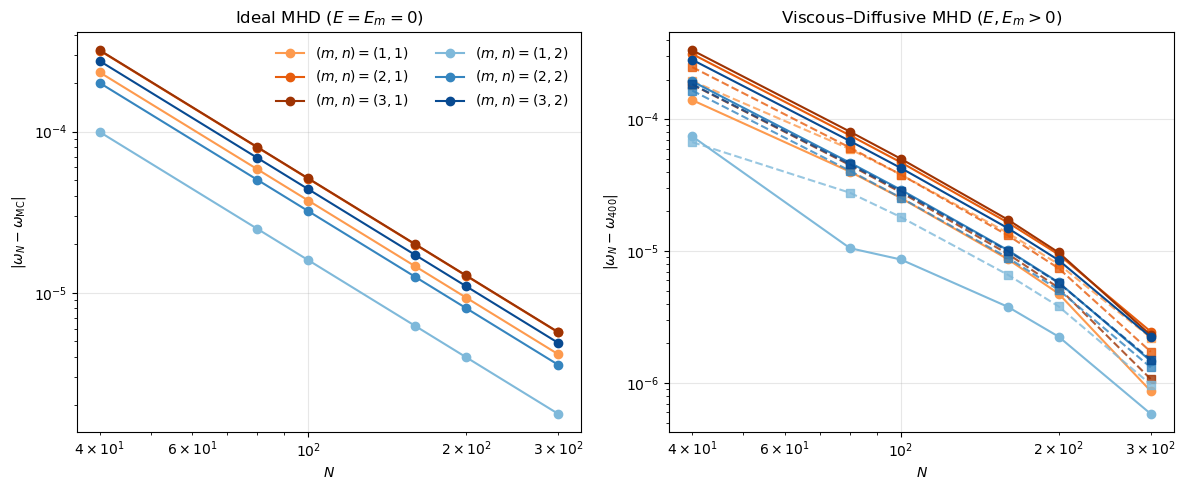

In [ ]:
N_list = [40, 80, 100, 160, 200, 300]

def convergence_errors(
    N_list,
    *,
    m,
    n_axial,
    eta=0.0,
    mu=0.0,
    N_ref=400,
):
    """
    Returns Re and Im convergence errors for a given (m, n_axial).
    """

    # --- Reference
    if eta == 0.0 and mu == 0.0:
        out_ref = solve_mhd_evp(
            N_ref, eta=0.0, mu=0.0, m=m, n_axial=n_axial
        )
        omega_ref = out_ref["omega_MC"]
    else:
        out_ref = solve_mhd_evp(
            N_ref, eta=eta, mu=mu, m=m, n_axial=n_axial
        )
        omega_ref = out_ref["omega"]

    err_re, err_im = [], []

    for N in N_list:
        out = solve_mhd_evp(
            N, eta=eta, mu=mu, m=m, n_axial=n_axial
        )
        ω = out["omega"]

        if eta == 0.0 and mu == 0.0:
            err_re.append(abs(ω.real - omega_ref))
            err_im.append(abs(ω.imag))   # Im(ω_MC)=0
        else:
            err_re.append(abs(ω.real - omega_ref.real))
            err_im.append(abs(ω.imag - omega_ref.imag))

    return np.array(err_re), np.array(err_im)


modes = [
    (1, 1),
    (2, 1),
    (3, 1),
    (1, 2),
    (2, 2),
    (3, 2),
]

# mêmes palettes de couleurs que la figure Le–ω
colors_n1 = mpl.cm.Oranges(np.linspace(0.45, 0.9, 3))  # m = 1,2,3 ; n=1
colors_n2 = mpl.cm.Blues(np.linspace(0.45, 0.9, 3))    # m = 1,2,3 ; n=2

color_map = {
    (1, 1): colors_n1[0],
    (2, 1): colors_n1[1],
    (3, 1): colors_n1[2],
    (1, 2): colors_n2[0],
    (2, 2): colors_n2[1],
    (3, 2): colors_n2[2],
}

def plot_reference_slope(ax, N_list, p, ref_value, label):
    N_ref = np.array(N_list)
    ax.loglog(
        N_ref,
        ref_value * (N_ref / N_ref[0])**(-p),
        "k--",
        lw=2,
        label=label
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# ============================
# IDEAL MHD
# ============================
ax = axes[0]

for (m, n) in modes:
    err_re, _ = convergence_errors(
        N_list,
        m=m,
        n_axial=n,
        eta=0.0,
        mu=0.0,
    )

    ax.loglog(
        N_list,
        err_re,
        "o-",
        color=color_map[(m, n)],
        label=fr"$(m,n)=({m},{n})$"
    )

ax.set_title(r"Ideal MHD ($E=E_m=0$)")
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$|\omega_N - \omega_{\mathrm{MC}}|$")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=2)


# ============================
# DISSIPATIVE MHD
# ============================
ax = axes[1]

for (m, n) in modes:
    err_re, err_im = convergence_errors(
        N_list,
        m=m,
        n_axial=n,
        eta=1e-2,
        mu=1e-2,
    )

    color = color_map[(m, n)]

    # --- Re(omega)
    ax.loglog(
        N_list,
        err_re,
        "o-",
        color=color,
        label=fr"Re $(m,n)=({m},{n})$"
    )

    # --- Im(omega)
    ax.loglog(
        N_list,
        err_im,
        "s--",
        color=color,
        alpha=0.8,
    )

ax.set_title(r"Viscous–Diffusive MHD ($E,E_m>0$)")
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$|\omega_N - \omega_{400}|$")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Inertial & Alfvèn limits

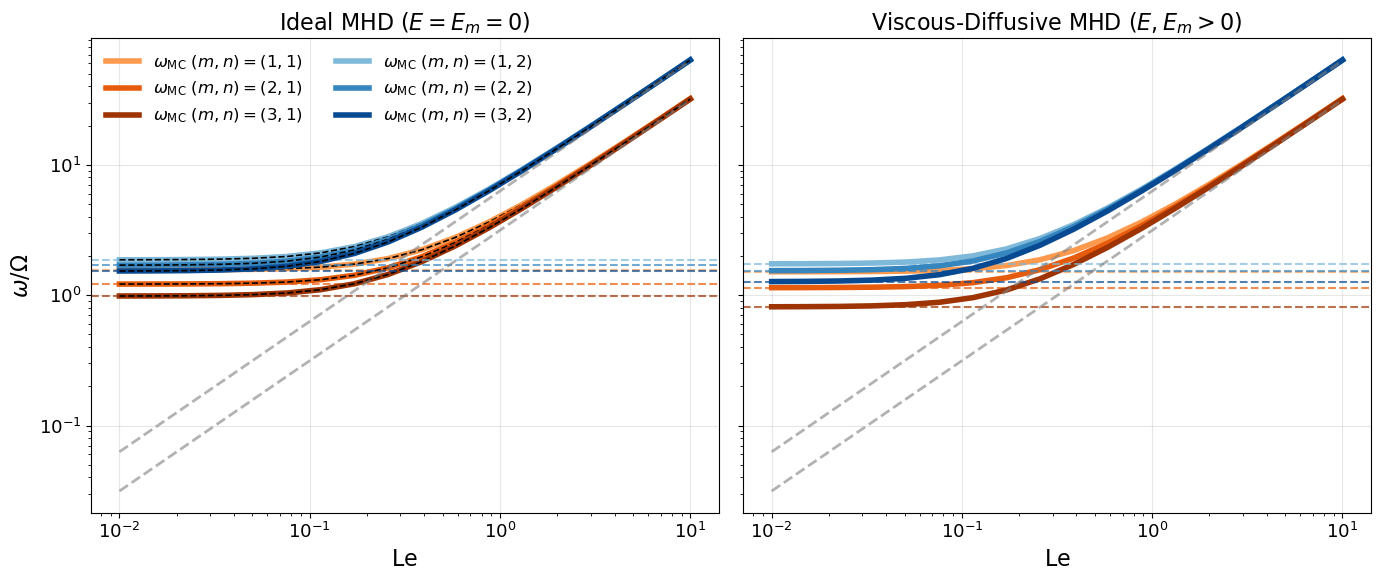

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ============================================================
# Style graphique
# ============================================================
mpl.rcParams.update({
    "font.size": 13,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "lines.linewidth": 3.0,
})

# ============================================================
# Paramètres globaux
# ============================================================
Omega = 1.0
h = 1.0
a = 1.0
N_evp = 80

Le_list = np.logspace(-2, 1, 18)

# dissipation
eta = 1e-2
mu  = 1e-2

# Modes
modes = [(1,1), (2,1), (3,1), (1,2), (2,2), (3,2)]

# Couleurs par famille n
colors_n1 = mpl.cm.Oranges(np.linspace(0.45, 0.9, 3))
colors_n2 = mpl.cm.Blues(np.linspace(0.45, 0.9, 3))


def plot_modes_vs_Le(
    ax,
    *,
    modes,
    Le_list,
    Omega,
    h,
    a,
    N_evp,
    eta,
    mu,
    ideal,
    colors,
):
    """
    ideal = True  -> cas idéal (MC analytique + EVP pointillé)
    ideal = False -> cas visqueux-diffusif (EVP plein)
    """

    for (m, n) in modes:
        color = colors[(m, n)]
        k = n * np.pi / h

        # =====================================================
        # Fréquence inertielle de référence
        # =====================================================
        out_I = solve_mhd_evp(
            N=N_evp,
            m=m,
            n_axial=n,
            B0=0.0,
            eta=0.0 if ideal else eta,
            mu=0.0 if ideal else mu,
        )
        omega_I = out_I["omega"].real / Omega

        ax.axhline(
            omega_I,
            color=color,
            lw=1.5,
            ls="--",
            alpha=0.7,
        )

        # =====================================================
        # CAS IDÉAL : MC analytique + EVP pointillé
        # =====================================================
        if ideal:
            # --- MC analytique
            omega_MC = np.array([
                omega_MC_ideal(
                    m=m,
                    n=n,
                    h=h,
                    a=a,
                    Omega_rot=Omega,
                    Le=Le,
                    k=k
                ) / Omega
                for Le in Le_list
            ])

            ax.loglog(
                Le_list,
                omega_MC,
                color=color,
                lw=4.0,
                label=fr"$\omega_{{\rm MC}}$ $(m,n)=({m},{n})$"
            )

            # --- EVP numérique idéal (pointillé noir)
            omega_num = []
            for Le in Le_list:
                B0 = Le * Omega * h
                out = solve_mhd_evp(
                    N=N_evp,
                    m=m,
                    n_axial=n,
                    B0=B0,
                    eta=0.0,
                    mu=0.0,
                )
                omega_num.append(out["omega"].real / Omega)

            ax.loglog(
                Le_list,
                omega_num,
                "--",
                color="black",
                lw=1.2,
            )

        # =====================================================
        # CAS VISQUEUX–DIFFUSIF : EVP plein
        # =====================================================
        else:
            omega_num = []
            for Le in Le_list:
                B0 = Le * Omega * h
                out = solve_mhd_evp(
                    N=N_evp,
                    m=m,
                    n_axial=n,
                    B0=B0,
                    eta=eta,
                    mu=mu,
                )
                omega_num.append(out["omega"].real / Omega)

            ax.loglog(
                Le_list,
                omega_num,
                "-",
                color=color,
                lw=4.0,
                label=fr"$(m,n)=({m},{n})$"
            )

    # =====================================================
    # Asymptotes Alfvén
    # =====================================================
    for n in [1, 2]:
        ax.loglog(
            Le_list,
            n * np.pi * Le_list,
            "--",
            color="gray",
            lw=2,
            alpha=0.6,
        )
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Cas idéal
plot_modes_vs_Le(
    axes[0],
    modes=modes,
    Le_list=Le_list,
    Omega=Omega,
    h=h,
    a=a,
    N_evp=N_evp,
    eta=0.0,
    mu=0.0,
    ideal=True,
    colors=color_map,
)
axes[0].set_title(r"Ideal MHD ($E=E_m=0$)")

# --- Cas visqueux–diffusif
plot_modes_vs_Le(
    axes[1],
    modes=modes,
    Le_list=Le_list,
    Omega=Omega,
    h=h,
    a=a,
    N_evp=N_evp,
    eta=eta,
    mu=mu,
    ideal=False,
    colors=color_map,
)
axes[1].set_title(r"Viscous-Diffusive MHD ($E,E_m>0$)")

# --- Axes
for ax in axes:
    ax.set_xlabel(r"$\mathrm{Le}$")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel(r"$\omega / \Omega$")

axes[0].legend(ncol=2, frameon=False)

plt.tight_layout()
plt.show()


## 2D Slice Plot

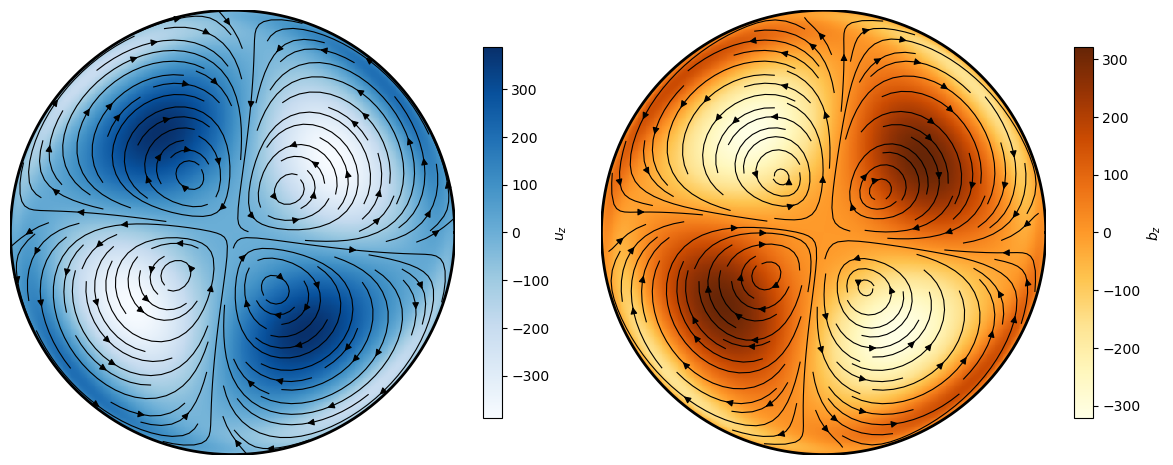

In [34]:
def extract_fields(u_dom, indices):
    """
    Extract T, P, G, F from eigenvector
    """
    T_idx, P_idx, G_idx, F_idx = indices
    return (
        u_dom[T_idx],
        u_dom[P_idx],
        u_dom[G_idx],
        u_dom[F_idx],
    )

def make_grids(s, h, m, k, omega, t=0):
    n = len(s)
    phi = np.linspace(0, 2*np.pi, n)
    z = np.linspace(0, h, n)
    S, PHI, Z = np.meshgrid(s, phi, z, indexing="ij")
    phase = np.exp(1j * (k*Z + m*PHI + omega*t))
    return S, PHI, Z, phase

def compute_field_components(
    u_dom, s, indices, m, k, omega, D, h, t=0, kind="velocity"
):
    T, P, G, F = extract_fields(u_dom, indices)

    F1, F2 = (T, P) if kind == "velocity" else (G, F)
    D_F2 = D @ F2

    S, PHI, Z, phase = make_grids(s, h, m, k, omega, t)

    F1 = F1[:, None, None]
    F2 = F2[:, None, None]
    DF2 = D_F2[:, None, None]

    S2 = S**2

    comp_s = (k**2 * F2 * S2 + m**2 * F2)
    comp_phi = (1j * k * F1 * S2 + 1j * m * S * DF2 - 1j * m * F2)
    comp_z = (1j * k * DF2 * S2 + 1j * k * S * F2 - 1j * m * F1)

    return (
        S, PHI, Z,
        (comp_s * phase).real,
        (comp_phi * phase).real,
        (comp_z * phase).real,
    )

def velocity(u, s, indices, m, k, omega, D, h, t=0):
    return compute_field_components(u, s, indices, m, k, omega, D, h, t, "velocity")

def magnetic(u, s, indices, m, k, omega, D, h, t=0):
    return compute_field_components(u, s, indices, m, k, omega, D, h, t, "magnetic")

def cylindrical_to_cartesian(S, PHI, vs, vphi):
    X = S * np.cos(PHI)
    Y = S * np.sin(PHI)
    ux = vs * np.cos(PHI) - vphi * np.sin(PHI)
    uy = vs * np.sin(PHI) + vphi * np.cos(PHI)
    return X, Y, ux, uy

def interpolate_cartesian(X, Y, *fields, Ncart=500):
    x_lin = np.linspace(-1, 1, Ncart)
    y_lin = np.linspace(-1, 1, Ncart)
    XC, YC = np.meshgrid(x_lin, y_lin)

    points = np.vstack([X.ravel(), Y.ravel()]).T
    out = []
    for f in fields:
        out.append(griddata(points, f.ravel(), (XC, YC), method="linear"))

    return x_lin, y_lin, XC, YC, out

def plot_velocity_magnetic(
    out,
    *,
    h=1.0,
    m=2,
    n_axial=1,
    z_frac=0.3,
    t=1.0,
    Ncart=500,
):
    u = out["solution"]
    s = out["s"]
    indices = out["indices"]
    omega = out["omega"]

    D, _ = cheb_diff(len(s) - 1)
    k = n_axial * np.pi / h

    # ---- champs cylindriques
    S, PHI, Z, vs, vphi, vz = velocity(u, s, indices, m, k, omega, D, h, t)
    _, _, _, bs, bphi, bz = magnetic(u, s, indices, m, k, omega, D, h, t)

    # ---- coupe z
    z0 = z_frac * h
    z_idx = np.argmin(np.abs(Z[0, 0, :] - z0))

    vs, vphi, vz = vs[:, :, z_idx], vphi[:, :, z_idx], vz[:, :, z_idx]
    bs, bphi, bz = bs[:, :, z_idx], bphi[:, :, z_idx], bz[:, :, z_idx]

    S2D, PHI2D = S[:, :, z_idx], PHI[:, :, z_idx]

    # ---- cartésien
    X, Y, ux, uy = cylindrical_to_cartesian(S2D, PHI2D, vs, vphi)
    _, _, bx, by = cylindrical_to_cartesian(S2D, PHI2D, bs, bphi)

    # ---- interpolation
    x_lin, y_lin, XC, YC, (uxC, uyC, uzC, bxC, byC, bzC) = interpolate_cartesian(
        X, Y, ux, uy, vz, bx, by, bz, Ncart=Ncart
    )

    # ---- plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Velocity
    ax = axes[0]
    pc = ax.pcolormesh(XC, YC, uzC, cmap="Blues", shading="auto")
    fig.colorbar(pc, ax=ax, label=r"$u_z$", shrink=0.65)
    ax.streamplot(x_lin, y_lin, uxC, uyC, color="k", density=1.4, linewidth=0.8)

    # Magnetic
    ax = axes[1]
    pc = ax.pcolormesh(XC, YC, bzC, cmap="YlOrBr", shading="auto")
    fig.colorbar(pc, ax=ax, label=r"$b_z$", shrink=0.65)
    ax.streamplot(x_lin, y_lin, bxC, byC, color="k", density=1.4, linewidth=0.8)

    theta = np.linspace(0, 2*np.pi, 400)
    for ax in axes:
        ax.plot(np.cos(theta), np.sin(theta), "k", lw=2)
        ax.set_aspect("equal")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

out = solve_mhd_evp(
    N=200,
    m=2,
    n_axial=1,
    eta=0.001,
    mu=1e-7,
)

plot_velocity_magnetic(out, h=1.0, m=2, n_axial=1, z_frac=0.3, t=1000.0)


## Energies

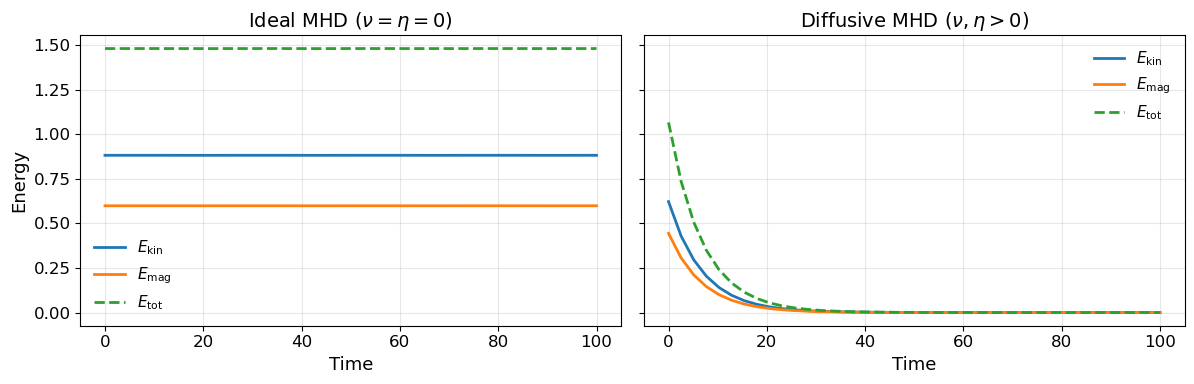

{'ideal': (array([0.88156374, 0.88160796, 0.88164464, 0.8816577 , 0.8816414 ,
         0.8816029 , 0.88155909, 0.8815292 , 0.88152633, 0.88155176,
         0.88159432, 0.88163534, 0.88165683, 0.88164935, 0.88161619,
         0.8815719 , 0.88153592, 0.88152403, 0.88154145, 0.88158054,
         0.88162415, 0.88165314, 0.8816548 , 0.8816284 , 0.88158552,
         0.88154498, 0.88152456, 0.88153324, 0.88156719, 0.88161153,
         0.8816468 , 0.88165753, 0.88163901, 0.88159936, 0.881556  ,
         0.88152793, 0.88152749, 0.88155486, 0.88159803, 0.88163808]),
  array([0.59857387, 0.59860387, 0.59862876, 0.59863762, 0.59862656,
         0.59860044, 0.59857072, 0.59855044, 0.59854849, 0.59856574,
         0.59859462, 0.59862245, 0.59863703, 0.59863195, 0.59860946,
         0.59857941, 0.59855499, 0.59854693, 0.59855875, 0.59858527,
         0.59861486, 0.59863453, 0.59863565, 0.59861774, 0.59858865,
         0.59856114, 0.59854729, 0.59855318, 0.59857621, 0.5986063 ,
         0.59863023, 0.

In [133]:
# ============================================================
# Style graphique global
# ============================================================
mpl.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "lines.linewidth": 2,
})


# ============================================================
# ÉNERGIES À UN INSTANT DONNÉ
# ============================================================
def compute_energies_at_time(
    out,
    *,
    h=1.0,
    m=2,
    n_axial=1,
    rho=1.0,
    mu0=1.0,
    t=0.0,
):
    u = out["solution"]
    s = out["s"]
    indices = out["indices"]
    omega = out["omega"]

    D, _ = cheb_diff(len(s) - 1)
    k = n_axial * np.pi / h

    # --- Velocity
    _, _, _, vs, vphi, vz = velocity(
        u, s, indices, m, k, omega, D, h, t
    )

    Ek = 0.5 * rho * np.mean(vs**2 + vphi**2 + vz**2)

    # --- Magnetic field
    _, _, _, bs, bphi, bz = magnetic(
        u, s, indices, m, k, omega, D, h, t
    )

    Em = 0.5 * (1 / mu0) * np.mean(bs**2 + bphi**2 + bz**2)

    return Ek, Em, Ek + Em


# ============================================================
# SÉRIE TEMPORELLE DES ÉNERGIES
# ============================================================
def energy_time_series(
    out,
    times,
    *,
    h=1.0,
    m=2,
    n_axial=1,
    rho=1.0,
    mu0=1.0,
):
    Ev, Eb, Et = [], [], []

    for t in times:
        Ek, Em, Etot = compute_energies_at_time(
            out,
            h=h,
            m=m,
            n_axial=n_axial,
            rho=rho,
            mu0=mu0,
            t=t,
        )
        Ev.append(Ek)
        Eb.append(Em)
        Et.append(Etot)

    return np.array(Ev), np.array(Eb), np.array(Et)


# ============================================================
# RÉSULTAT ÉNERGIES
# ============================================================
def result_energy(
    *,
    N=100,
    m=2,
    n_axial=1,
    h=1.0,
    rho=1.0,
    mu0=1.0,
    times=None,
    nu_diff=1e-2,
    eta_diff=1e-2,
):
    """
    Compare l'évolution des énergies :
    - cas idéal (nu = eta = 0)
    - cas diffusif (nu, eta > 0)

    """

    if times is None:
        times = np.linspace(0, 100, 40)

    # ============================
    # Cas idéal
    # ============================
    out_ideal = solve_mhd_evp(
        N=N,
        m=m,
        n_axial=n_axial,
        eta=0.0,
        mu=0.0,
    )

    Ev_i, Eb_i, Et_i = energy_time_series(
        out_ideal,
        times,
        h=h,
        m=m,
        n_axial=n_axial,
        rho=rho,
        mu0=mu0,
    )

    # ============================
    # Cas diffusif
    # ============================
    out_diff = solve_mhd_evp(
        N=N,
        m=m,
        n_axial=n_axial,
        eta=eta_diff,
        mu=nu_diff,
    )

    Ev_d, Eb_d, Et_d = energy_time_series(
        out_diff,
        times,
        h=h,
        m=m,
        n_axial=n_axial,
        rho=rho,
        mu0=mu0,
    )

    # ============================
    # PLOT
    # ============================
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --- Ideal
    ax = axes[0]
    ax.plot(times, Ev_i, label=r"$E_{\rm kin}$")
    ax.plot(times, Eb_i, label=r"$E_{\rm mag}$")
    ax.plot(times, Et_i, label=r"$E_{\rm tot}$", ls="--")

    ax.set_title(r"Ideal MHD ($\nu=\eta=0$)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy")
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)

    # --- Diffusive
    ax = axes[1]
    ax.plot(times, Ev_d, label=r"$E_{\rm kin}$")
    ax.plot(times, Eb_d, label=r"$E_{\rm mag}$")
    ax.plot(times, Et_d, label=r"$E_{\rm tot}$", ls="--")

    ax.set_title(r"Diffusive MHD ($\nu,\eta>0$)")
    ax.set_xlabel("Time")
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return {
        "ideal": (Ev_i, Eb_i, Et_i),
        "diffusive": (Ev_d, Eb_d, Et_d),
        "times": times,
    }


# ============================================================
# UTILISATION
# ============================================================
result_energy(
    N=100,
    m=2,
    n_axial=1,
    nu_diff=0.01,
    eta_diff=1e-7,
)
